In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('house_price_data.csv')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

# Detect outliers in numerical columns (based on 3 standard deviations)
outliers = df.select_dtypes(include=[np.number]).apply(lambda x: np.sum(np.abs(x - x.mean()) > 3 * x.std()))
print("\nOutliers (3-sigma rule):\n", outliers)

# Display summary statistics
summary_stats = df.describe(include='all')
print("\nSummary Statistics:\n", summary_stats)

# Show data types
data_types = df.dtypes
print("\nData Types:\n", data_types)


Missing Values:
 property_id                0
neighborhood               0
distance_to_city_center    0
distance_to_metro          0
distance_to_school         0
crime_rate                 0
house_age                  0
total_area                 0
bedrooms                   0
bathrooms                  0
floors                     0
garage                     0
garden                     0
basement                   0
balcony                    0
construction_quality       0
renovation_status          0
heating_type               0
air_conditioning           0
parking_spaces             0
energy_efficiency          0
listing_duration           0
season_sold                0
year_sold                  0
sale_price                 0
dtype: int64

Outliers (3-sigma rule):
 distance_to_city_center    175
distance_to_metro          162
distance_to_school         168
crime_rate                   0
house_age                  147
total_area                 103
bedrooms                     0
b

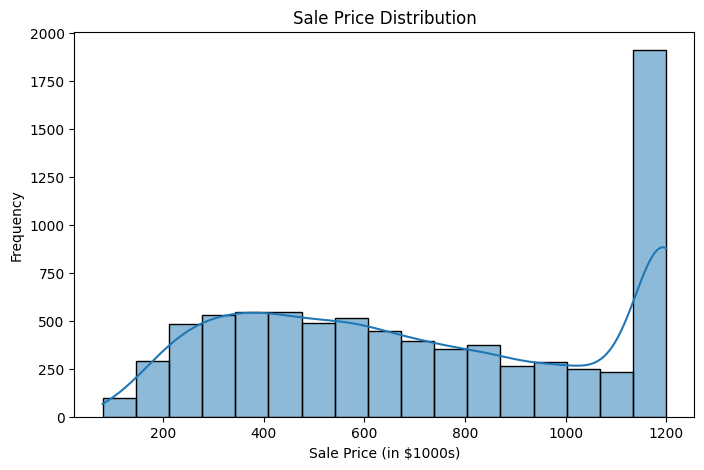

Skewness of Sale Price: 0.07300029773629817


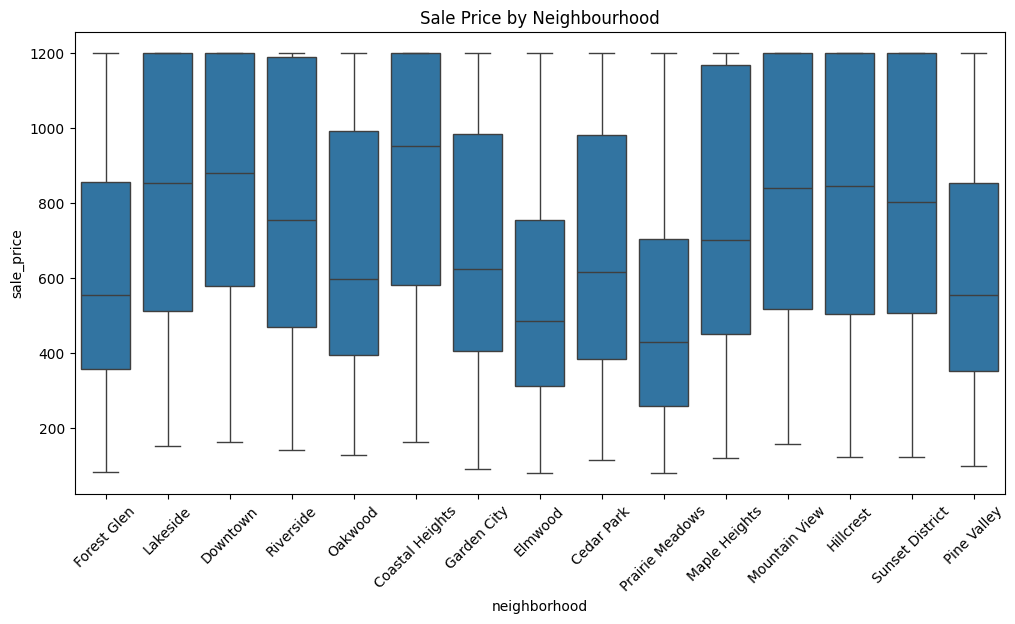

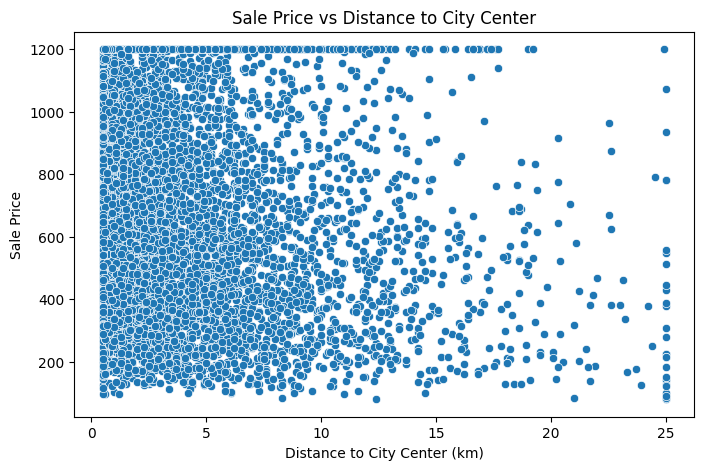

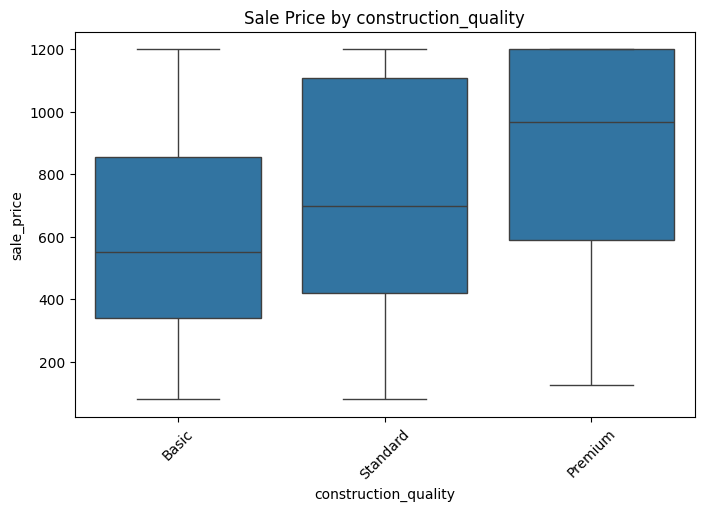

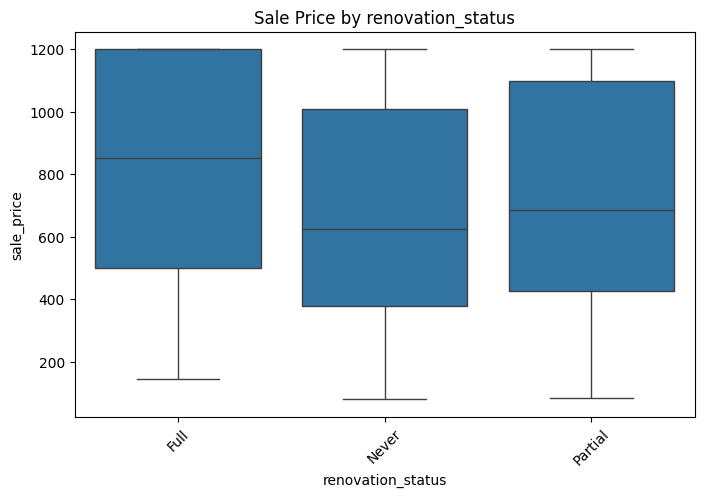

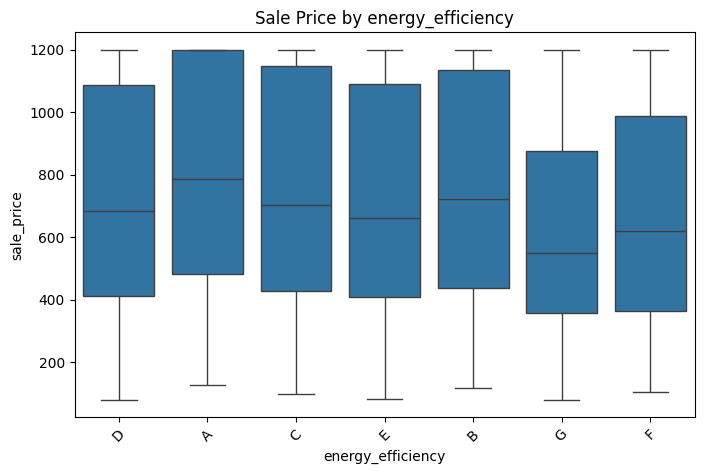

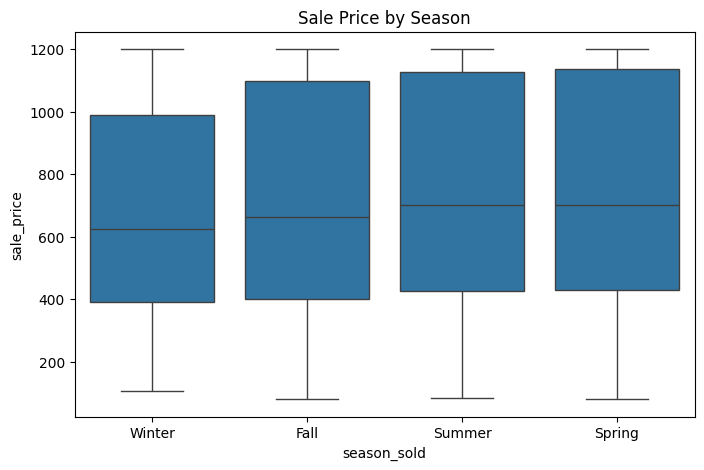

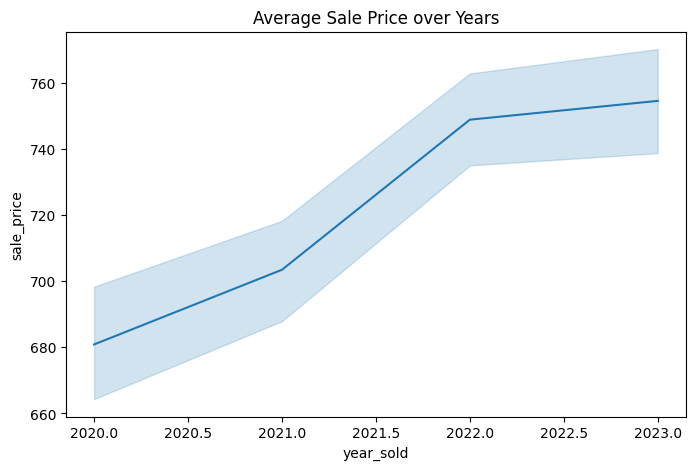

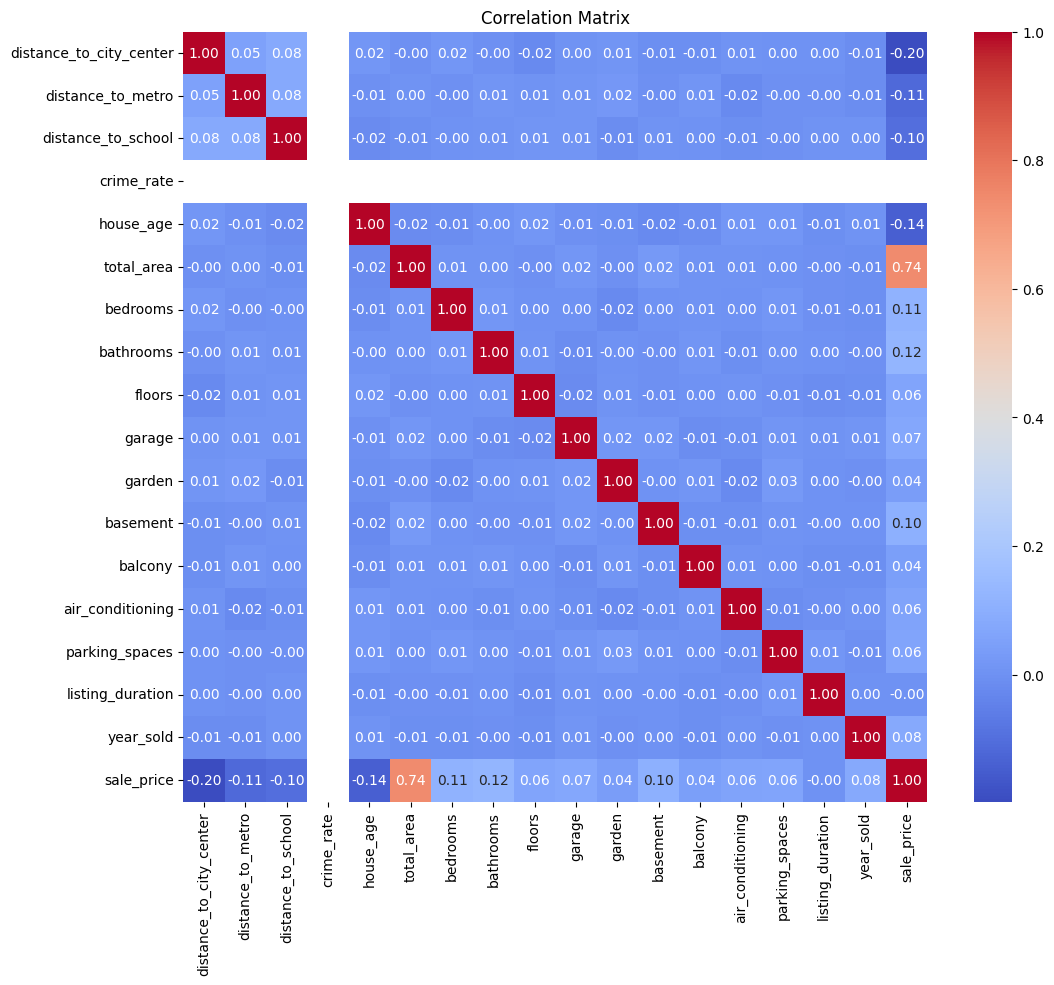

Highly correlated pairs (threshold > 0.8):
 Empty DataFrame
Columns: []
Index: []


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('house_price_data.csv')

# --- 1. Analyse price distribution and check for skewness ---
plt.figure(figsize=(8, 5))
sns.histplot(df['sale_price'], kde=True)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price (in $1000s)')
plt.ylabel('Frequency')
plt.show()

print("Skewness of Sale Price:", df['sale_price'].skew())

# --- 2. Examine location impact and property feature relationships ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='neighborhood', y='sale_price', data=df)
plt.xticks(rotation=45)
plt.title('Sale Price by Neighbourhood')
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='distance_to_city_center', y='sale_price', data=df)
plt.title('Sale Price vs Distance to City Center')
plt.xlabel('Distance to City Center (km)')
plt.ylabel('Sale Price')
plt.show()

# --- 3. Investigate quality factors and market timing effects ---
quality_features = ['construction_quality', 'renovation_status', 'energy_efficiency']
for feature in quality_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=feature, y='sale_price', data=df)
    plt.title(f'Sale Price by {feature}')
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='season_sold', y='sale_price', data=df)
plt.title('Sale Price by Season')
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(x='year_sold', y='sale_price', data=df)
plt.title('Average Sale Price over Years')
plt.show()

# --- 4. Correlation analysis and multicollinearity ---
numerical_df = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Optional: Identify high multicollinearity pairs
threshold = 0.8
high_corr = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]
print("Highly correlated pairs (threshold > 0.8):\n", high_corr.dropna(how='all').dropna(axis=1, how='all'))

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load data
df = pd.read_csv('house_price_data.csv')
print("Columns in dataset:", df.columns.tolist())

# Check required columns before using
if 'area' in df.columns and 'sale_price' in df.columns:
    df['price_per_sqft'] = df['sale_price'] * 1000 / df['area']
else:
    print("Skipping 'price_per_sqft' — 'area' or 'sale_price' column not found.")

if 'age' in df.columns and 'renovation_status' in df.columns:
    df['age_renovated'] = np.where(df['renovation_status'] == 'Recently Renovated', df['age'] * 0.5, df['age'])
else:
    print("Skipping 'age_renovated' — 'age' or 'renovation_status' column not found.")

# Identify columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns=['sale_price'], errors='ignore').columns.tolist()

# Outlier capping with IQR
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

print("Outliers capped for numeric columns.")

# Drop highly correlated features
corr_matrix = df[numerical_cols].corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
df.drop(columns=to_drop, inplace=True)
numerical_cols = [col for col in numerical_cols if col not in to_drop]
print("Dropped due to multicollinearity:", to_drop)

# Prepare data
if 'sale_price' not in df.columns:
    raise ValueError("Target column 'sale_price' not found in dataset!")

X = df.drop('sale_price', axis=1)
y = df['sale_price']

# Preprocessing pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Transform and split
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("Data split complete:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Columns in dataset: ['property_id', 'neighborhood', 'distance_to_city_center', 'distance_to_metro', 'distance_to_school', 'crime_rate', 'house_age', 'total_area', 'bedrooms', 'bathrooms', 'floors', 'garage', 'garden', 'basement', 'balcony', 'construction_quality', 'renovation_status', 'heating_type', 'air_conditioning', 'parking_spaces', 'energy_efficiency', 'listing_duration', 'season_sold', 'year_sold', 'sale_price']
Skipping 'price_per_sqft' — 'area' or 'sale_price' column not found.
Skipping 'age_renovated' — 'age' or 'renovation_status' column not found.
Outliers capped for numeric columns.
Dropped due to multicollinearity: []
Data split complete:
X_train shape: (6400, 8052)
X_test shape: (1600, 8052)


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output results
print("\nLinear Regression Model Results:")
print("RMSE:", round(rmse, 2))
print("R² Score:", round(r2, 4))



Linear Regression Model Results:
RMSE: 133.72
R² Score: 0.8532



Linear Regression Performance:
MAE: 104.79
MSE: 17880.23
RMSE: 133.72
R² Score: 0.8532

Random Forest Performance:
MAE: 97.34
MSE: 17385.21
RMSE: 131.85
R² Score: 0.8573


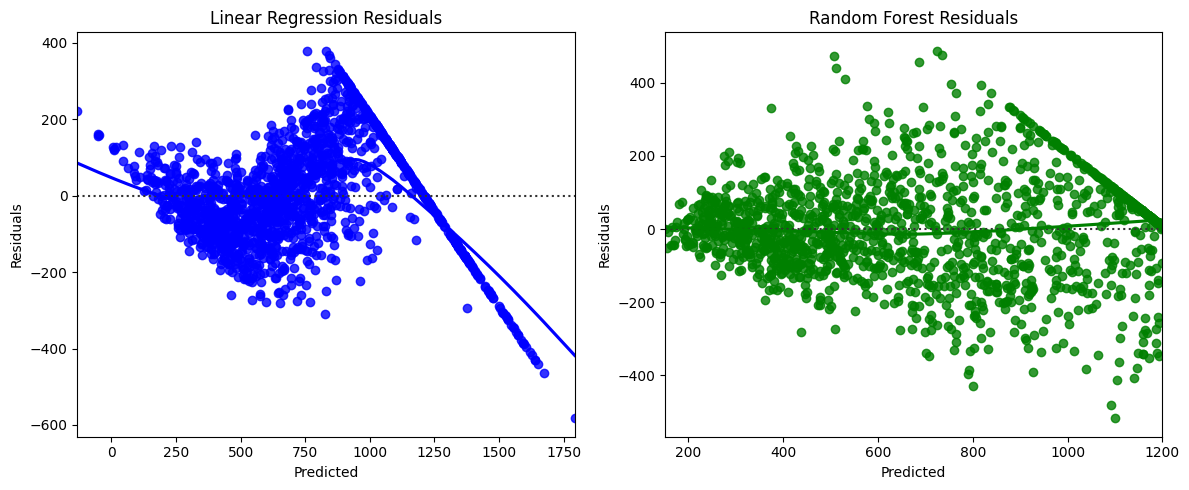


✅ Best Model: Random Forest (Lowest RMSE: 131.85)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Train Models ---
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

# --- 2. Predictions ---
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)

# --- 3. Evaluation Function ---
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    return {'model': model_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")

# --- 4. Residual Plots ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.residplot(x=lr_pred, y=(y_test - lr_pred), lowess=True, color='blue')
plt.title('Linear Regression Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.residplot(x=rf_pred, y=(y_test - rf_pred), lowess=True, color='green')
plt.title('Random Forest Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# --- 5. Compare and Select Best Model ---
model_results = pd.DataFrame([lr_metrics, rf_metrics])
best_model = model_results.sort_values(by='RMSE').iloc[0]

print(f"\n✅ Best Model: {best_model['model']} (Lowest RMSE: {best_model['RMSE']:.2f})")
